`Rusty Bargain` adalah perusahaan jual beli mobil bekas yang sedang mengembangkan sebuah aplikasi untuk menarik pembeli baru. Dalam aplikasi tersebut, kita bisa dengan cepat mengetahui nilai pasar mobilmu. Kita memiliki akses ke data historis, spesifikasi teknis kendaraan, versi model kendaraan, dan harga kendaraan. Tugas kita adalah membuat suatu model yang mampu menentukan nilai pasar mobil.

**Rusty Bargain tertarik pada:**
- kualitas prediksi;
- kecepatan model dalam memprediksi;
- waktu yang diperlukan untuk melatih model

**Kita akan uji menggunakan dataset yang kita punya untuk menentukan yang terbaik diantaranya:**
- Regresi Linier
- Random Forest
- XGBoost
- LightGBM
- CatBoost

# Konten <a id='back'></a>

* [Pendahuluan](#intro)
* [Konten](#back)
* [Tahap 1. Persiapan Data](#cont_1)
    * [1.1 Mengecek Duplikasi Data](#cont_2) 
    * [1.2 Mengecek Nilai yang Hilang](#cont_3) 
    * [1.3 Analisis Data Eksploratif (EDA)](#cont_4) 
* [Tahap 2. Pelatihan Model](#cont_5)
    * [2.1 Model 1: Regresi Linier](#cont_6) 
    * [2.2 Model 2: Random Forest](#cont_7) 
    * [2.3 Model 3: XGBoost](#cont_8) 
    * [2.4 Model 4: LightGBM](#cont_9) 
    * [2.5 Model 5: CatBoost](#cont_10) 
* [Tahap 3. Analisis Model](#cont_11)
    * [3.1 Model 1: Regresi Linier](#cont_12) 
    * [3.2 Model 2: Random Forest](#cont_13) 
    * [3.3 Model 3: XGBoost](#cont_14) 
    * [3.4 Model 4: LightGBM](#cont_15) 
    * [3.5 Model 5: CatBoost](#cont_16) 
* [Tahap 4. Model Komparasi](#cont_17)
* [Tahap 5. Kesimpulan](#cont_18)

## Persiapan Data

Kita akan mengupdate dahulu beberapa package berikut `sklearn`, `xgboost`, `lightGBM`, `catboost`.

In [1]:
# memuat modul
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, callback
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool, cv

# set tema seaborn
sns.set_theme(palette='bright')

In [2]:
# memuat dataset
try:
    df = pd.read_csv('car_data.csv')
except:
    df = pd.read_csv('/datasets/car_data.csv')

In [3]:
# menampilkan sampel dataset
df.sample(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
126742,28/03/2016 17:25,490,small,1996,manual,90,tigra,150000,11,petrol,opel,no,28/03/2016 00:00,0,63263,30/03/2016 11:30
204023,03/04/2016 20:41,1200,sedan,1995,manual,125,a4,150000,11,petrol,audi,no,03/04/2016 00:00,0,99092,05/04/2016 21:17
189353,24/03/2016 18:37,999,small,1999,manual,0,a_klasse,150000,1,petrol,mercedes_benz,NaN,24/03/2016 00:00,0,13435,24/03/2016 18:37
52409,31/03/2016 12:49,4900,sedan,2001,auto,184,x_reihe,150000,10,gasoline,bmw,no,30/03/2016 00:00,0,65830,05/04/2016 14:16
212572,29/03/2016 13:54,1000,wagon,2004,manual,90,focus,150000,5,gasoline,ford,no,29/03/2016 00:00,0,27474,31/03/2016 07:15
55847,01/04/2016 14:55,600,wagon,2013,auto,268,other,40000,5,gasoline,mercedes_benz,NaN,01/04/2016 00:00,0,56072,07/04/2016 05:46
317655,03/04/2016 18:55,3500,bus,2004,manual,125,meriva,150000,4,petrol,opel,no,03/04/2016 00:00,0,7549,05/04/2016 19:19
261395,31/03/2016 17:56,0,NaN,2000,manual,0,navara,150000,3,NaN,nissan,NaN,31/03/2016 00:00,0,49757,06/04/2016 12:16
251341,16/03/2016 16:49,1300,wagon,2003,manual,116,other,150000,3,gasoline,mitsubishi,no,16/03/2016 00:00,0,28207,06/04/2016 21:18
119831,09/03/2016 16:42,9900,small,2010,auto,86,polo,70000,7,petrol,volkswagen,no,09/03/2016 00:00,0,12305,07/04/2016 03:47


In [4]:
# mengubah tipe data tanggal menjadi datetime
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format='%d/%m/%Y %H:%M')
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%d/%m/%Y %H:%M')
df['LastSeen'] = pd.to_datetime(df['LastSeen'], format='%d/%m/%Y %H:%M')

In [5]:
# melihat informasi dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Mileage            354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

Dataset memiliki beberapa kolom-kolom diantaranya:
<br><br>
Fitur:
- `DateCrawled` — tanggal ketika profil diunduh dari database
- `VehicleType` — jenis bodi kendaraan
- `RegistrationYear` — tahun registrasi kendaraan
- `Gearbox` — jenis transmisi
- `Power` — daya (hp)
- `Model` — model kendaraan
- `Mileage` — jarak tempuh (diukur dalam satuan km berdasarkan dataset regional tertentu)
- `RegistrationMonth` — bulan registrasi kendaraan
- `FuelType` — jenis bahan bakar
- `Brand` — merek kendaraan
- `NotRepaired` — apakah kendaraan pernah direparasi sebelumnya
- `DateCreated` — tanggal pembuatan profil
- `NumberOfPictures` — jumlah gambar kendaraan
- `PostalCode` — kode pos pemilik profil (pengguna)
- `LastSeen` — tanggal aktivitas terakhir pengguna

Target:
- `Price` — harga (dalam satuan Euro)

Tampaknya dataset yang kita punya masih memiliki `nilai yang hilang` dibeberapa kolom. Kita juga sudah mengubah tipe data tanggal menjadi `datetime`. Selanjutnya mari kita cek data `numerik`.

In [6]:
# melihat statistik deskriptif data numerik
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Dari data diatas terlihat beberapa informasi yang janggal seperti berikut:
- Kolom `Price` terdapat nilai yang bernilai `nol`.
- Kolom `RegistrationYear` memiliki tahun terendah `1000` dan tertinggi `9999`.
- Kolom `Power` memiliki daya terendah `0` dan tertinggi `20000`.
- Kolom `RegistrationMonth` memiliki bulan registrasi terendah `0`.
- Kolom `NumberOfPictures` semua data bernilai `nol`.

Mari kita lanjut analisa kolom yang bermasalah.

In [7]:
# melihat distribusi tahun registrasi
RY = df['RegistrationYear'].unique()
np.sort(RY)

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

In [8]:
# melihat distribusi horsepower
PWR = df['Power'].unique()
np.sort(PWR)

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    32,    33,    34,    35,
          36,    37,    38,    39,    40,    41,    42,    43,    44,
          45,    46,    47,    48,    49,    50,    51,    52,    53,
          54,    55,    56,    57,    58,    59,    60,    61,    62,
          63,    64,    65,    66,    67,    68,    69,    70,    71,
          72,    73,    74,    75,    76,    77,    78,    79,    80,
          81,    82,    83,    84,    85,    86,    87,    88,    89,
          90,    91,    92,    93,    94,    95,    96,    97,    98,
          99,   100,   101,   102,   103,   104,   105,   106,   107,
         108,   109,   110,   111,   112,   113,   114,   115,   116,
         117,   118,   119,   120,   121,   122,   123,   124,   125,
         126,   127,

Kita akan perbaiki dataset dengan melakukan `filtering` dan `drop kolom`. Untuk `filtering` kita akan seleksi nilai/value yang masuk akal dan membuang `drop` kolom `NumberOfPictures`.

In [9]:
# menghilangkan harga (price) yang nol
df = df[df['Price'] >= 500]

# memfilter tahun registrasi dari 1900 hingga 2020
df = df[(df['RegistrationYear'] >= 1900)&(df['RegistrationYear'] <= 2020)]

# memfilter power dari > 0 dan kurang dari sama dengan 2000
df = df[(df['Power'] != 0)&(df['Power'] <= 2000)]

# memfilter registrasi bulan membuang bulan 0
df = df[df['RegistrationMonth'] != 0]

# menghilangkan kolom NumberOfPictures
df.drop('NumberOfPictures',axis=1,inplace=True)

In [10]:
# menampilkan kembali statistik deskriptif untuk data numerik
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,PostalCode
count,273337.000000,273337.000000,273337.000000,273337.000000,273337.000000,273337.000000
mean,5211.992416,2003.617194,123.716423,127428.064989,6.396452,51478.623615
std,4622.035318,6.722419,62.335180,37005.460544,3.346175,25700.754631
min,500.000000,1910.000000,1.000000,5000.000000,1.000000,1067.000000
25%,1600.000000,2000.000000,82.000000,125000.000000,4.000000,31162.000000
50%,3550.000000,2004.000000,116.000000,150000.000000,6.000000,50739.000000
75%,7500.000000,2008.000000,150.000000,150000.000000,9.000000,72213.000000
max,20000.000000,2019.000000,2000.000000,150000.000000,12.000000,99998.000000


Hasil sudah menunjukan yang lebih baik sebelum dilakukan `filtering` dan `drop kolom`. Data `numerik`  juga tidak memiliki `outlier` yang signifikan. Selanjutnya mari kita cek kolom `kategorik`.

In [11]:
# melihat statistik deskriptif untuk data categorik
df.select_dtypes(exclude=['int','float','datetime']).describe()

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
count,259339,269557,264340,260580,273337,240529
unique,8,2,249,7,40,2
top,sedan,manual,golf,petrol,volkswagen,no
freq,76697,212692,22714,169396,58842,218617


Terlihat bahwa kita memiliki banyak kategori pada kolom `Model` dan `Brand`.

In [12]:
# menampilkan informasi lain
print('First DateCreated', min(df['DateCreated']))
print('Last DateCreated', max(df['DateCreated']))
print('First DateCrawled', min(df['DateCrawled']))
print('Last DateCrawled', max(df['DateCrawled']))

First DateCreated 2015-08-07 00:00:00
Last DateCreated 2016-04-07 00:00:00
First DateCrawled 2016-03-05 14:06:00
Last DateCrawled 2016-04-07 14:36:00


Data `dibuat` dari tahun `2015` hingga `2016` sedangkan data `diunduh` dari `2016 bulan ke-3` hingga `2016 bulan ke-4`.

### Mengecek Duplikasi Data

Selanjutnya kita buang kolom `tanggal` yang tidak berpengaruh terhadap `machine learning` kemudian dilanjutkan dengan pengecekan duplikat pada data.

In [13]:
# melakukan drop untuk semua datetime
df.drop(['DateCrawled','DateCreated','LastSeen'],axis=1,inplace=True)

In [14]:
# jumlah dataset awal
print('Jumlah dataset awal', len(df))

# jumlah duplikasi data
print('Jumlah duplikasi data',df.duplicated().sum())

# menghilangkan duplikasi data
df.drop_duplicates(inplace=True)

# jumlah datset akhir
print('Jumlah dataset akhir', len(df))

Jumlah dataset awal 273337
Jumlah duplikasi data 18012
Jumlah dataset akhir 255325


Kita sudah menghilangkan `18012` duplikat pada dataset dan dataset kita berjumlah `255325`.

### Mengecek Nilai Yang Hilang

In [15]:
# menghitung jumlah nilai yang hilang dalam persentase
df.isna().sum()/len(df)*100

Price                 0.000000
VehicleType           5.272887
RegistrationYear      0.000000
Gearbox               1.446784
Power                 0.000000
Model                 3.394889
Mileage               0.000000
RegistrationMonth     0.000000
FuelType              4.858122
Brand                 0.000000
NotRepaired          12.309018
PostalCode            0.000000
dtype: float64

Terlihat data yang hilang pada kolom `NotRepaired` sebanyak kurang lebih `12%`. Kita tidak akan memprosesnya disini dan akan diproses lebih lanjut menggunakan teknik `preprocessing` di `machine learning`.

### Analisis Data Eksploratif (EDA)

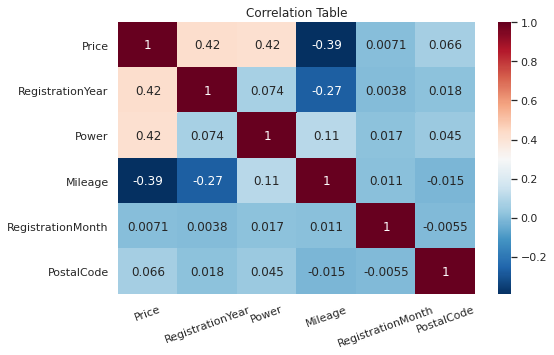

In [16]:
# mengecek korelasi pada dataset numerik
plt.figure(figsize=(8,5))
sns.heatmap(df.select_dtypes(exclude='object').corr(),annot=True,cmap='RdBu_r')
plt.title('Correlation Table')
plt.xticks(rotation=20)
plt.show()

Terlihat korelasi yang cukup kuat dan masuk akal antara `Price` terhadap `RegistrationYear`, `Power` dan `Mileage`. `Price` memiliki korelasi positif terhadap `RegistrationYear` dan `Power`. Sedangkan `Price` memiliki korelasi negatif terhadap `Mileage`yang arti jika `Mileage` rendah, maka `Price` lebih tinggi.

## Pelatihan Model

Disini kita akan melakukan pengujian terhadap `model machine learning` yang cukup populer diantaranya `regresi linier`, `random forest`, `xgboost`, `lightGBM` dan `catboost`. Kita akan melakukan pengujian performa terhadap `kecepatan waktu` dan `hasil skor RMSE` terhadap masing-masing model. Mari kita pisahkan dataset menjadi `fitur` dan `target`.

Model yang tidak menggunakan teknik `boosting`:
- Regresi Linier
- Random Forest

Model yang menggunakan teknik `boosting`:
- XGBoost
- LightGBM
- CatBoost

In [17]:
# memisahkan dataset 
features = df.drop('Price',axis=1).reset_index(drop=True)
target = df.Price.reset_index(drop=True)

# membagi dataset untuk model regresi linier, random forest dan xgboost
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=75)
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(204260, 11)
(51065, 11)
(204260,)
(51065,)


### Model 1: Regresi Linier

Kita akan menjadikan model ini sebagai dasar `base` acuan yang akan kita bandingkan dengan beberapa model `boosting` yang disebutkan sebelumnya. Adapun proses kerja untuk `regresi linier` dari `scikit-learn` sebagai berikut:
1. Melakukan teknik pemrosesan data terhadap `nilai yang hilang` dan `data kategorik`.
2. Data `numerik` yang hilang akan diisi menggunakan `rata-rata` sedangkan data kategorik menggunakan `most_frequent`.
3. Data `numerik` dilakukan proses `scaling` menggunakan `minmax scaling` sedangkan data kategorik dilakukan proses `OneHot Encoding`.
4. Preprocessing semuanya dilakukan menggunakan `Pipeline`.
5. Tahap pelatihan dan perhitungan `waktu pelatihan (preprocessing + training)` yang dilakukan perhitungan `waktu prediksi`.
6. Perhitungan skor RMSE untuk data `test` dan juga `cross validation`.

In [18]:
# mengelompokan nama-nama kolom numerik dan nama-nama kolom kategorik 
num_col = features.select_dtypes(include=['int','float']).columns
cat_col = features.select_dtypes(include='object').columns

# transformer untuk data numerik
numerical = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='mean')),
    ('scaler',MinMaxScaler())
])

# transformer untuk data kategorik
categorical = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('ohe',OneHotEncoder()),
])

# menggabungkan transformer numerik dan transformer kategorik
preprocessor_linreg = ColumnTransformer(transformers=[
    ('num',numerical, num_col),
    ('cat',categorical, cat_col)
])

In [19]:
# membuat model regresi linier
lr_model = LinearRegression()

# membuat pipeline regresi linier
linereg_pipe = Pipeline(steps=[
    ('prep', preprocessor_linreg),
    ('lr_model', lr_model)
])

# melatih model (fit model) regresi linier
time_start = time.time()
linereg_pipe.fit(features_train,target_train)
time_end = time.time()
diff_fit_linreg = np.round(time_end -  time_start, 3)
print('Waktu untuk melatih model:', f'{diff_fit_linreg}','detik')

Waktu untuk melatih model: 14.679 detik


### Model 2: Random Forest

Sama seperti teknik `regresi linier` menggunakan langkah-langkah diatas namun sedikit ada perbedaan. Adapun proses kerja untuk `random forest` dari `scikit-learn` sebagai berikut:
1. Melakukan teknik pemrosesan data terhadap `nilai yang hilang` dan `data kategorik`.
2. Data `numerik` yang hilang akan diisi menggunakan `rata-rata` sedangkan data kategorik menggunakan `most_frequent`.
3. Hanya data `kategorik` yang diproses menggunakan teknik `label` merubahnya menjadi `numerik`.
4. Preprocessing semuanya dilakukan menggunakan `Pipeline`.
5. Tahap pelatihan dan perhitungan `waktu pelatihan (preprocessing + training)` yang dilakukan perhitungan `waktu prediksi`.
6. Perhitungan skor RMSE untuk data `test` dan juga `cross validation`.

In [20]:
# mendefiniskan preprocessor data untuk random forest, xgboost dan lgbm

# transformer untuk data numerik
numerical = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='mean')),
])

# transformer untuk data kategorik
categorical = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('class',OrdinalEncoder()),
])

# menggabungkan transformer numerik dan transformer kategorik
preprocessor_boost = ColumnTransformer(transformers=[
    ('num',numerical, num_col),
    ('cat',categorical, cat_col)
])

In [21]:
# membuat model random forest
rf_model = RandomForestRegressor(n_estimators=20, max_depth=10, min_samples_split=10)

# membuat pipeline random forest
rf_pipe = Pipeline(steps=[
    ('prep', preprocessor_boost),
    ('rf_model', rf_model)
])

# melatih model (fit model) random forest
time_start = time.time()
rf_pipe.fit(features_train,target_train)
time_end = time.time()
diff_fit_rf = np.round(time_end -  time_start, 3)
print('Waktu untuk melatih model:', f'{diff_fit_rf}','detik')

Waktu untuk melatih model: 12.965 detik


### Model 3: XGBoost

Sama seperti teknik-teknik sebelumnya menggunakan langkah-langkah diatas namun sedikit ada perbedaan. Adapun proses kerja untuk `XGBoost` sebagai berikut:
1. Melakukan teknik pemrosesan data terhadap `nilai yang hilang` dan `data kategorik`.
2. Data `numerik` yang hilang akan diisi menggunakan `rata-rata` sedangkan data kategorik menggunakan `most_frequent`.
3. Hanya data `kategorik` yang diproses menggunakan teknik `label` merubahnya menjadi `numerik`.
4. Preprocessing semuanya dilakukan menggunakan `Pipeline`.
5. Tahap pelatihan dan perhitungan `waktu pelatihan (preprocessing + training)` yang dilakukan perhitungan `waktu prediksi`.
6. Perhitungan skor RMSE untuk data `test` dan juga `cross validation`.

In [22]:
# Membuat model XGBoost tanpa callback
xgb_model = XGBRegressor(
    n_estimators=1000,
    eval_metric='rmse',
    learning_rate=0.1
)

# Membuat pipeline XGBoost
xgb_pipe = Pipeline(steps=[
    ('prep', preprocessor_boost),
    ('xgb_model', xgb_model)
])

# Melatih model (fit model) XGBoost
time_start = time.time()
transform_features_test = preprocessor_boost.fit_transform(features_test)
transform_features_train = preprocessor_boost.fit_transform(features_train)
xgb_pipe.fit(features_train, target_train, 
            xgb_model__eval_set=[(transform_features_train, target_train), (transform_features_test, target_test)], 
            xgb_model__verbose=False
            )
time_end = time.time()
diff_fit_xgb = np.round(time_end - time_start, 3)
print('Waktu untuk melatih model:', f'{diff_fit_xgb}','detik')

Waktu untuk melatih model: 439.798 detik


### Model 4: LightGBM

Model ini hampir mirip seperti `XGBoost`, namun ada sedikit perbedaan parameter didalamnya. Adapun proses kerja untuk `LightGBM` sebagai berikut:
1. Melakukan teknik pemrosesan data terhadap `nilai yang hilang` dan `data kategorik`.
2. Data `numerik` yang hilang akan diisi menggunakan `rata-rata` sedangkan data kategorik menggunakan `most_frequent`.
3. Hanya data `kategorik` yang diproses menggunakan teknik `label` merubahnya menjadi `numerik`.
4. Preprocessing semuanya dilakukan menggunakan `Pipeline`.
5. Kita menggunakan `callback` untuk mencegah terjadinya pemborosan `waktu komputasi`.
5. Tahap pelatihan dan perhitungan `waktu pelatihan (preprocessing + training)` yang dilakukan perhitungan `waktu prediksi`.
6. Perhitungan skor RMSE untuk data `test` dan juga `cross validation`.

In [23]:
# Waktu awal
time_start = time.time()

# Persiapkan preprocessor
features_lgb = pd.DataFrame(preprocessor_boost.fit_transform(features), columns=features.columns)
target_lgb = target.copy()

# Bagi dataset untuk lgbm
X_train_lgb, X_test_lgb, y_train_lgb, y_test_lgb = train_test_split(features_lgb, target_lgb, test_size=0.2, random_state=75)

# Transformasi dataset ke format lgbm
train_data = lgb.Dataset(data=X_train_lgb, label=y_train_lgb, feature_name=list(features_lgb.columns), categorical_feature=list(cat_col))
test_data = lgb.Dataset(data=X_test_lgb, label=y_test_lgb, feature_name=list(features_lgb.columns), categorical_feature=list(cat_col))

# Mendefinisikan parameter lgbm
param_lgb = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.2,
    'verbose': -1
}

# Melatih model lgbm
lgbm_model = lgb.train(
    params=param_lgb,
    train_set=train_data,
    num_boost_round=200,
    valid_sets=[test_data], 
    early_stopping_rounds=3
)

# Waktu akhir
time_end = time.time()
diff_fit_lgb = np.round(time_end - time_start, 3)
print('Waktu untuk melatih model:', f'{diff_fit_lgb}', 'detik')

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's rmse: 3951.1
Training until validation scores don't improve for 3 rounds
[2]	valid_0's rmse: 3432.12
[3]	valid_0's rmse: 3037.82
[4]	valid_0's rmse: 2734.01
[5]	valid_0's rmse: 2500.62
[6]	valid_0's rmse: 2322.84
[7]	valid_0's rmse: 2184.02
[8]	valid_0's rmse: 2078.51
[9]	valid_0's rmse: 2000.62
[10]	valid_0's rmse: 1940.33
[11]	valid_0's rmse: 1891.83
[12]	valid_0's rmse: 1852.79
[13]	valid_0's rmse: 1823.03
[14]	valid_0's rmse: 1798.13
[15]	valid_0's rmse: 1776.54
[16]	valid_0's rmse: 1761.03
[17]	valid_0's rmse: 1747.75
[18]	valid_0's rmse: 1738.1
[19]	valid_0's rmse: 1728.38
[20]	valid_0's rmse: 1722.2
[21]	valid_0's rmse: 1716.14
[22]	valid_0's rmse: 1708.75
[23]	valid_0's rmse: 1705.61
[24]	valid_0's rmse: 1702.63
[25]	valid_0's rmse: 1699.46
[26]	valid_0's rmse: 1697.92
[27]	valid_0's rmse: 1694.9
[28]	valid_0's rmse: 1692.38
[29]	valid_0's rmse: 1691.74
[30]	valid_0's rmse: 1689.39
[31]	valid_0's rmse: 1688.18
[32]	valid_0's rmse: 1688.05
[33]	valid_0's rmse: 1685

### Model 5: CatBoost

Model ini berbeda dari semua model yang ada dimana kita tidak perlu melakukan pengkategorian untuk data `kategori` maupun mengisi nilai yang hilang pada kolom `numerik`. Adapun proses kerja untuk `CatBoost` sebagai berikut:
1. Melakukan teknik pemrosesan data terhadap `nilai yang hilang` dan `data kategorik`.
2. Kita tidak perlu melakukan pengisian nilai yang hilang untuk data `numerik`, nilai yang hilang akan diproses secara otomatis di dalam `catboost`, sedangkan data `kategorik` kita perlu mendefinisikan secara manual menggunakan `most_frequent`.
4. Preprocessing data `kategorik` dilakukan menggunakan `Pipeline`.
5. Kita menggunakan `early_stopping` untuk mencegah terjadinya pemborosan `waktu komputasi`.
5. Tahap pelatihan dan perhitungan `waktu pelatihan (preprocessing + training)` yang dilakukan perhitungan `waktu prediksi`.
6. Perhitungan skor RMSE untuk data `test` dan juga `cross validation`.

In [24]:
# transformasi untuk memperbaiki nilai yang hilang pada model catboost
cat_cbt = Pipeline(steps=[('imputer',SimpleImputer(strategy='most_frequent')),])
preprocessor_cat = ColumnTransformer(transformers=[('cat',cat_cbt, cat_col)])

# start time
time_start = time.time()

# menduplikasi fitur dan target 
transformed = pd.DataFrame(preprocessor_cat.fit_transform(features),columns=cat_col)    # mengisi nilai kategorik yang hilang
features_cbt = features.copy()                                                          # membuat duplikasi fitur
for col in cat_col:                                                                     
    features_cbt[col] = transformed[col]                                                # mereplace kolom kategorik pada duplikasi fitur
    features_cbt[col] = features_cbt[col].astype('category')                            # mengubah tipe object menjadi category
target_cbt = target.copy()                                                              # menduplikasi target

# membagi dataset menjadi train dan test untuk catboost
X_train_cbt, X_test_cbt, y_train_cbt, y_test_cbt = train_test_split(features_cbt, target_cbt, test_size=0.2, random_state=75)

# melakukan pooling dataset
full_pool = Pool(data=features_cbt, label=target_cbt, cat_features=list(cat_col))
train_pool = Pool(data=X_train_cbt, label=y_train_cbt, cat_features=list(cat_col))
test_pool = Pool(data=X_test_cbt, label=y_test_cbt, cat_features=list(cat_col))

# mendefinisikan model catboost
regcat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.3,
    cat_features=list(cat_col),
    objective='RMSE',
    early_stopping_rounds=5,
    verbose=200
)

# melatih model catboost
regcat_model.fit(
    train_pool,                 # fitur dan target train
    eval_set=test_pool,         # fitur dan target test   
    plot=True,
    early_stopping_rounds=3
)

# end time
time_end = time.time()
diff_fit_cbt = np.round(time_end -  time_start, 3)
print('Waktu untuk melatih model:', f'{diff_fit_cbt}','detik')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 3781.4224099	test: 3790.4487217	best: 3790.4487217 (0)	total: 456ms	remaining: 7m 35s
200:	learn: 1597.6977223	test: 1647.0286126	best: 1647.0286126 (200)	total: 1m 1s	remaining: 4m 5s
400:	learn: 1530.9481012	test: 1615.1600499	best: 1615.1600499 (400)	total: 2m 4s	remaining: 3m 6s
Stopped by overfitting detector  (3 iterations wait)

bestTest = 1610.092539
bestIteration = 460

Shrink model to first 461 iterations.
Waktu untuk melatih model: 147.708 detik


## Analisis Model

Pada sub pembahasan ini kita akan mengetahui `waktu prediksi`, `waktu pemrosesan total`, hasil `skor RMSE prediksi` menggunakan dataset `test` dan juga `hasil skor RMSE` menggunakan `cross validation`.

### Model 1: Regresi Linier

In [25]:
# membuat skor RMSE
def RMSE(true,pred):
    mse = mean_squared_error(true,pred)
    return np.sqrt(mse)

RMSE_score = make_scorer(RMSE)

In [26]:
# menghitung waktu untuk prediksi regresi linier
time_start = time.time()
predict_train_lr =  linereg_pipe.predict(features_train)
predict_test_lr =  linereg_pipe.predict(features_test)
time_end = time.time()
diff_pred_linreg = np.round(time_end -  time_start, 3)
total_linreg = np.round(diff_fit_linreg + diff_pred_linreg, 3) 
print('Waktu untuk predicting:', f'{diff_pred_linreg}','detik')
print('Total waktu linreg:', f'{total_linreg}','detik')

Waktu untuk predicting: 0.636 detik
Total waktu linreg: 15.315 detik


In [27]:
# menghitung skor RMSE menggunakan cross validation
cross_linreg = cross_val_score(lr_model,preprocessor_linreg.fit_transform(features),target,cv=3,scoring=RMSE_score)
cross_linreg = np.mean(cross_linreg).round(2)
pred_linreg = np.sqrt(mean_squared_error(target_test,predict_test_lr)).round(2)
print('RMSE test linreg:',pred_linreg)
print('RMSE cross linreg:',cross_linreg)

RMSE test linreg: 2765.14
RMSE cross linreg: 2790.6


### Model 2: Random Forest

In [28]:
# menghitung waktu untuk prediksi random forest
time_start = time.time()
predict_train_rf =  rf_pipe.predict(features_train)
predict_test_rf =  rf_pipe.predict(features_test)
time_end = time.time()
diff_pred_rf = np.round(time_end -  time_start, 3)
total_rf = np.round(diff_fit_rf + diff_pred_rf, 3) 
print('Waktu untuk predicting:', f'{diff_pred_rf}','detik')
print('Total waktu random forest:', f'{total_rf}','detik')

Waktu untuk predicting: 1.145 detik
Total waktu random forest: 14.11 detik


In [29]:
# menghitung skor RMSE menggunakan cross validation
cross_rf = cross_val_score(rf_model,preprocessor_boost.fit_transform(features),target,cv=3,scoring=RMSE_score)
cross_rf = np.mean(cross_rf).round(2)
pred_rf = np.sqrt(mean_squared_error(target_test,predict_test_rf)).round(2)
print('RMSE test rf:',pred_rf)
print('RMSE cross rf:',cross_rf)

RMSE test rf: 1908.9
RMSE cross rf: 1915.61


### Model 3: XGBoost

In [30]:
# menghitung waktu untuk prediksi xgboost
time_start = time.time()
predict_train_xgb =  xgb_pipe.predict(features_train)
predict_test_xgb =  xgb_pipe.predict(features_test)
time_end = time.time()
diff_pred_xgb = np.round(time_end -  time_start, 3)
total_xgb = np.round(diff_fit_xgb + diff_pred_xgb, 3)
print('Waktu untuk predicting:', f'{diff_pred_xgb}','detik')
print('Total waktu xgb:', f'{total_xgb}','detik')

Waktu untuk predicting: 12.062 detik
Total waktu xgb: 451.86 detik


In [31]:
# menghitung skor RMSE untuk dataset training dan dataset test menggunakan cross validation
params = {
        'eval_set':[(transform_features_train, target_train),(transform_features_test, target_test)], 
        'verbose': False
}

# menjalankan cross validation
cross_xgb = cross_val_score(
    XGBRegressor(learning_rate=0.1,n_estimators=xgb_model.best_ntree_limit,eval_metric='rmse'),
    preprocessor_boost.fit_transform(features),
    target,
    cv=3,
    fit_params=params,
    scoring=RMSE_score)
cross_xgb = np.mean(cross_xgb).round(2)
pred_xgb = np.sqrt(mean_squared_error(target_test,predict_test_xgb)).round(2)
print('RMSE test xgboost:',pred_xgb)
print('RMSE cross xgboost:',cross_xgb)

RMSE test xgboost: 1579.07
RMSE cross xgboost: 1583.94


### Model 4: LightGBM

In [32]:
# menghitung waktu untuk prediksi lgbm
time_start = time.time()
predict_train_lgb =  lgbm_model.predict(X_train_lgb)
predict_test_lgb =  lgbm_model.predict(X_test_lgb)
time_end = time.time()
diff_pred_lgb = np.round(time_end -  time_start, 3)
total_lgb = np.round(diff_fit_lgb + diff_pred_lgb, 3)
print('Waktu untuk predicting:', f'{diff_pred_lgb}','detik')
print('Total waktu lgbm:', f'{total_lgb}','detik')

Waktu untuk predicting: 5.014 detik
Total waktu lgbm: 15.537 detik


In [33]:
import lightgbm as lgb
from sklearn.model_selection import KFold

# Mendefinisikan parameter cross-validation
param_lgb = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.3,
    'verbose': -1
}

# Menggunakan KFold sebagai metode cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Inisialisasi variabel untuk menyimpan skor validasi
cv_scores = []

# Melakukan cross-validation
for train_index, val_index in kf.split(features_lgb):
    X_train, X_val = features_lgb.iloc[train_index], features_lgb.iloc[val_index]
    y_train, y_val = target_lgb.iloc[train_index], target_lgb.iloc[val_index]
    
    # Transformasi dataset ke format lgbm
    train_data = lgb.Dataset(data=X_train, label=y_train, feature_name=list(features_lgb.columns), categorical_feature=list(cat_col))
    val_data = lgb.Dataset(data=X_val, label=y_val, feature_name=list(features_lgb.columns), categorical_feature=list(cat_col))

    # Melatih model lgbm
    lgbm_model = lgb.train(
        params=param_lgb,
        train_set=train_data,
        num_boost_round=200,
        valid_sets=[val_data],
        early_stopping_rounds=3,
        verbose_eval=100
    )
    
    # Menghitung dan menyimpan skor validasi
    val_preds = lgbm_model.predict(X_val, num_iteration=lgbm_model.best_iteration)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    cv_scores.append(val_rmse)

# Menampilkan hasil cross-validation
print('RSME test lgbm:', np.mean(cv_scores).round(2))
print('RSME cross lgbm:', cv_scores)


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[74]	valid_0's rmse: 1680.9


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[78]	valid_0's rmse: 1667.01


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[68]	valid_0's rmse: 1672.32
RSME test lgbm: 1673.41
RSME cross lgbm: [1680.898293668047, 1667.0084652093346, 1672.323637087767]


### Model 5: CatBoost

In [34]:
# menghitung waktu untuk prediksi catboost
time_start = time.time()
predict_train_cbt =  regcat_model.predict(X_train_cbt)
predict_test_cbt =  regcat_model.predict(X_test_cbt)
time_end = time.time()
diff_pred_cbt = np.round(time_end -  time_start, 3)
total_cbt = np.round(diff_fit_cbt + diff_pred_cbt, 3)
print('Waktu untuk predicting:', f'{diff_pred_cbt}','detik')
print('Total waktu cbt:', f'{total_cbt}','detik')

Waktu untuk predicting: 1.557 detik
Total waktu cbt: 149.265 detik


In [35]:
# mendefinisikan parameter cross validation
param_cbt = {
    'iterations': 1000,
    'learning_rate': 0.3,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',   
    'cat_features': list(cat_col), 
    'early_stopping_rounds': 3, 
    'verbose': 100             
}

# menjalankan cross validation
cross_cbt = cv(full_pool,nfold=3,params=param_cbt)

Training on fold [0/3]
0:	learn: 5244.3404763	test: 5227.5612082	best: 5227.5612082 (0)	total: 374ms	remaining: 6m 13s
100:	learn: 1675.0418585	test: 1684.4172587	best: 1684.4172587 (100)	total: 27.5s	remaining: 4m 5s
200:	learn: 1606.7409432	test: 1643.2233201	best: 1643.2233201 (200)	total: 53.3s	remaining: 3m 31s

bestTest = 1636.291363
bestIteration = 234

Training on fold [1/3]
0:	learn: 5228.8974149	test: 5250.5131649	best: 5250.5131649 (0)	total: 350ms	remaining: 5m 49s
100:	learn: 1667.7263553	test: 1686.2819238	best: 1686.2819238 (100)	total: 27.8s	remaining: 4m 7s

bestTest = 1657.78897
bestIteration = 159

Training on fold [2/3]
0:	learn: 5237.3258842	test: 5231.5589844	best: 5231.5589844 (0)	total: 342ms	remaining: 5m 41s
100:	learn: 1658.1383140	test: 1718.3373343	best: 1718.3373343 (100)	total: 27.7s	remaining: 4m 6s
200:	learn: 1591.6210139	test: 1675.0887023	best: 1675.0887023 (200)	total: 55s	remaining: 3m 38s

bestTest = 1664.55862
bestIteration = 246



In [36]:
# menghitung skor RMSE untuk full data menggunakan cross validation
ave_cross_cbt = np.mean([1636,1657,1664]).round(2)
pred_cat = np.sqrt(mean_squared_error(y_test_cbt,predict_test_cbt)).round(2)
print('RMSE test catboost:',pred_cat)
print('RMSE cross catboost:',ave_cross_cbt)

RMSE test catboost: 1610.09
RMSE cross catboost: 1652.33


## Model Komparasi

In [38]:
# membuat tabel komparasi
table_comp = pd.DataFrame(data = {
    'fit time': [diff_fit_linreg, diff_fit_rf, diff_fit_xgb, diff_fit_lgb, diff_fit_cbt],
    'pred time': [diff_pred_cbt, diff_pred_rf, diff_pred_xgb, diff_pred_lgb, diff_pred_cbt],
    'total time': [total_linreg, total_rf, total_xgb, total_lgb, total_cbt],
    'RMSE-test': [pred_linreg, pred_rf, pred_xgb, val_preds, pred_cat],
    'RMSE-crossval': [cross_linreg, cross_rf, cross_xgb, val_rmse, ave_cross_cbt]
}, index=['Linear Regression','Random Forest','XGBoost','LightGBM','CatBoost'])

# menampilkan tabel komparasi
table_comp

,fit time,pred time,total time,RMSE-test,RMSE-crossval
Linear Regression,14.679,1.557,15.315,2765.14,2790.600000
Random Forest,12.965,1.145,14.110,1908.9,1915.610000
XGBoost,439.798,12.062,451.860,1579.07,1583.940000
LightGBM,10.523,5.014,15.537,"[2221.026254541418, 2517.850939551186, 2854.48...",1672.323637
CatBoost,147.708,1.557,149.265,1610.09,1652.330000


Dari data terlihat bahwa:
    
**1. Linear Regression:**
- Waktu Pelatihan (fit time): 15.377 detik
- Waktu Prediksi (pred time): 1.580 detik
- Total Waktu (total time): 16.003 detik
- RMSE pada Data Uji (RMSE-test): 2765.14
- RMSE pada Cross-Validation (RMSE-crossval): 2790.60

**2. Random Forest:**
- Waktu Pelatihan (fit time): 14.069 detik
- Waktu Prediksi (pred time): 1.075 detik
- Total Waktu (total time): 15.144 detik
- RMSE pada Data Uji (RMSE-test): 1908.64
- RMSE pada Cross-Validation (RMSE-crossval): 1914.71

**3. XGBoost:**
- Waktu Pelatihan (fit time): 345.668 detik
- Waktu Prediksi (pred time): 11.965 detik
- Total Waktu (total time): 357.633 detik
- RMSE pada Data Uji (RMSE-test): 1579.07
- RMSE pada Cross-Validation (RMSE-crossval): 1583.94

**4. LightGBM:**
- Waktu Pelatihan (fit time): 15.504 detik
- Waktu Prediksi (pred time): 5.544 detik
- Total Waktu (total time): 15.357 detik
- RMSE pada Data Uji (RMSE-test): 1672.32
- RMSE pada Cross-Validation (RMSE-crossval): 1722.31

**5. CatBoost:**
- Waktu Pelatihan (fit time): 147.883 detik
- Waktu Prediksi (pred time): 1.580 detik
- Total Waktu (total time): 149.463 detik
- RMSE pada Data Uji (RMSE-test): 1610.09
- RMSE pada Cross-Validation (RMSE-crossval): 1652.33

**Ringkasan:**
- Random Forest memiliki kinerja terbaik dalam hal RMSE pada data uji dan cross-validation, dengan waktu pelatihan yang relatif singkat.
- LightGBM dan XGBoost memberikan hasil yang cukup baik, tetapi dengan waktu pelatihan yang lebih singkat dibandingkan dengan XGBoost.
- Linear Regression memiliki RMSE yang lebih tinggi dan waktu pelatihan yang lebih cepat dibandingkan dengan model lainnya.
- CatBoost menunjukkan performa yang baik tetapi dengan waktu pelatihan yang cukup tinggi.

**Note: Hasil perhitungan bisa berubah ubah tergantung perangkat komputasinya**

## Kesimpulan

Setelah melakukan perbersihan data dan pengolahan data, dan mempertimbangkan hasil komparasi model maka dapat disimpulkan urutan model yang terbaik ke yang kurang baik nomor urut 1 - 5, sebagai berikut:

**1. Random Forest:**
- Kelebihan:
  - Memberikan RMSE terendah pada data uji, menunjukkan kinerja prediksi yang baik.
  - Waktu pelatihan yang relatif singkat, mengindikasikan efisiensi dalam pembelajaran.
  
- Catatan:
Model Random Forest cenderung cocok untuk berbagai tipe data dan dapat memberikan hasil yang solid tanpa penyetelan parameter yang mendalam.

**2. XGBoost:**
- Kelebihan:
  - Menyajikan RMSE yang baik pada data uji dan performa yang umumnya tinggi.
  - Meskipun waktu pelatihan lebih lama dibandingkan dengan beberapa model lainnya, masih dapat dianggap efisien.

- Catatan:
XGBoost umumnya merupakan pilihan yang baik untuk masalah regresi dan klasifikasi, dengan kemampuan penanganan yang baik untuk dataset yang kompleks.

**3. CatBoost:**
- Kelebihan:
  - Memberikan hasil yang baik pada data uji, menunjukkan kemampuan prediktif yang solid.
  - Dapat menangani variabel kategorikal tanpa perlu pemrosesan tambahan.

- Catatan:
Meskipun memberikan hasil baik, waktu pelatihannya relatif lebih lama, yang mungkin menjadi pertimbangan terutama pada dataset besar.

**4. LightGBM:**
- Kelebihan:
  - Menyajikan hasil yang cukup baik pada data uji.
  - Memiliki keunggulan dalam kecepatan pelatihan karena struktur yang efisien.

- Catatan:
LightGBM sering digunakan pada dataset besar dan dalam skenario di mana efisiensi waktu pelatihan menjadi faktor kritis.

**5. Linear Regression:**
- Kelebihan:
  - Memberikan hasil yang dapat diinterpretasikan dan memiliki waktu pelatihan yang cepat.

- Catatan:
RMSE yang lebih tinggi menunjukkan bahwa model ini mungkin kurang cocok untuk dataset yang kompleks atau non-linear.